# Face Mask Detection Model

In [30]:
# import the necessary packages
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
import cv2,os
import pandas as pd
from scipy.spatial import distance
from tensorflow.keras.models import load_model
import argparse
import tensorflow as tf

In [2]:
# calling dataset
data_path= r"C:\Users\neenu\Desktop\Artificial Intelligence_Sem 1\AIDI-1003- Capstone Term I\CAPSTONE\DATASETS\dataset"

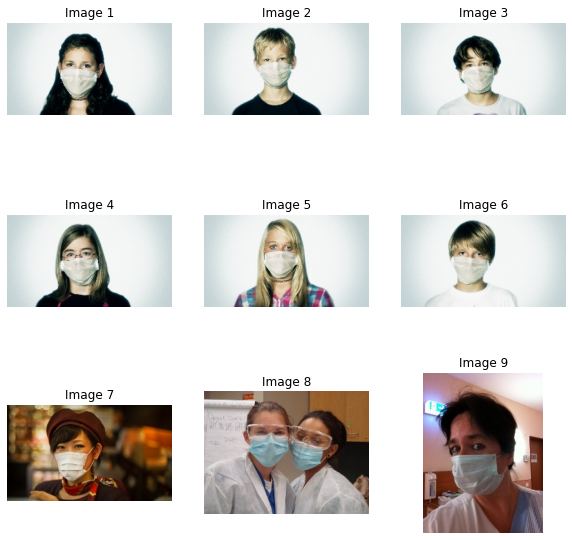

In [3]:
i = 0
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for dirname, _, filenames in os.walk(r'C:\Users\neenu\Desktop\Artificial Intelligence_Sem 1\AIDI-1003- Capstone Term I\CAPSTONE\DATASETS\dataset\with_mask'):
    for filename in filenames[:9]:
        img = cv2.imread(os.path.join(dirname, filename))
        if img is not None:
            #img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            ax = list(axes.flatten())[i]
            ax.imshow(img)
            ax.set_title('Image ' + str(i+1))
            ax.axis('off')
            i += 1
plt.show()

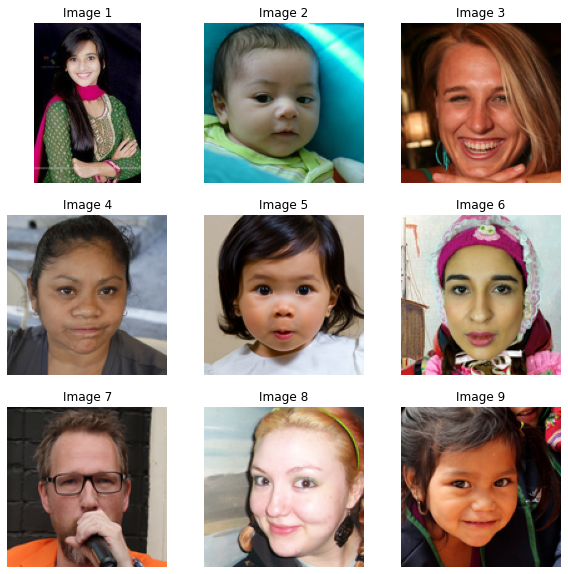

In [4]:
i = 0
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for dirname, _, filenames in os.walk(r'C:\Users\neenu\Desktop\Artificial Intelligence_Sem 1\AIDI-1003- Capstone Term I\CAPSTONE\DATASETS\dataset\without_mask'):
    for filename in filenames[:9]:
        img = cv2.imread(os.path.join(dirname, filename))
        if img is not None:
            #img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            ax = list(axes.flatten())[i]
            ax.imshow(img)
            ax.set_title('Image ' + str(i+1))
            ax.axis('off')
            i += 1
plt.show()

## Data preprocessing step

###### Labelled the data as 'with_mask': 0, 'without_mask’: 1
###### Converted the images to grayscale.
###### Resized the image to 100*100 for reducing the load on training the model.
###### Normalized the image by dividing 255, which will convert the pixel range into 0 and 1.

In [5]:
# The images were stored in a ‘dataset’ directory which had two folders, one titled ‘with mask’ and one titled ‘without mask’. These folder names became our class labels.

# calling dataset
data_path= r"C:\Users\neenu\Desktop\Artificial Intelligence_Sem 1\AIDI-1003- Capstone Term I\CAPSTONE\DATASETS\dataset"

# load folder name as categories
categories=os.listdir(data_path)

# array is created to call the number of folders inside the dataset.
labels=[i for i in range(len(categories))]

# a dictonary is created to zip the categories and label.
label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [6]:
# For each image in both folders, we used the cv2.cvtColor function to convert the BGR image to a Grayscale image. 
# We then used the cv2.resize function to resize our image to dimensions (img_size, img_size). 
# Our img_size parameter was set to 100, and so each image becomes a 100 x 100 square image. 
# The prepared image is appended to the ‘data’ list, and the class label is appended to the ‘target’ list.

# size is set to 100*100 and two empty list to save the images.
img_size=100
data=[]
target=[]

# We will call the two categories in the for loop here and then the image name from the folders.
for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)

# All the images from the image path is calling here
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale

            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100*100, since we need a fixed common size for all the images in the dataset
            
            data.append(resized)
            # add the prepared image into the data array
            
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [7]:
"""To reduce model complexity and optimize training time, we can first convert the ‘data’ list to a more efficient numpy array, 
and then divide the array by 255-this will normalise the pixel range to between 0 and 1. The data will have dimensions 
(no. of images, img_size, img_size, colour channel). The ‘target’ list can also be converted to a numpy array and then converted
to a one-hot encoding vector. np.save saves the arrays to a binary file in numpy format."""

# normalize image by 255 which will convert the pixel range into 0 and 1.
data=np.array(data)/255.0

# data will have a shape of (number of images,h,w,colour channel)
data=np.reshape(data,(data.shape[0],img_size,img_size,1))

# turn the target array as np array
target=np.array(target)

from keras.utils import np_utils

# convert array of labeled data(from 0 to nb_classes - 1) to one-hot vector.
new_target=np_utils.to_categorical(target)

In [8]:
np.save('data',data) #images
np.save('target',new_target) #target values 0/1

# Training the model

## Convolutional Neural Network (CNN)

In [9]:
# loading the data and target numpy arrays.

data=np.load('data.npy')
target=np.load('target.npy')

In [10]:
data.shape

(10000, 100, 100, 1)

In [11]:
data.shape[1:]

(100, 100, 1)

In [12]:
target.shape

(10000, 2)

###### An Example how CNN works
 
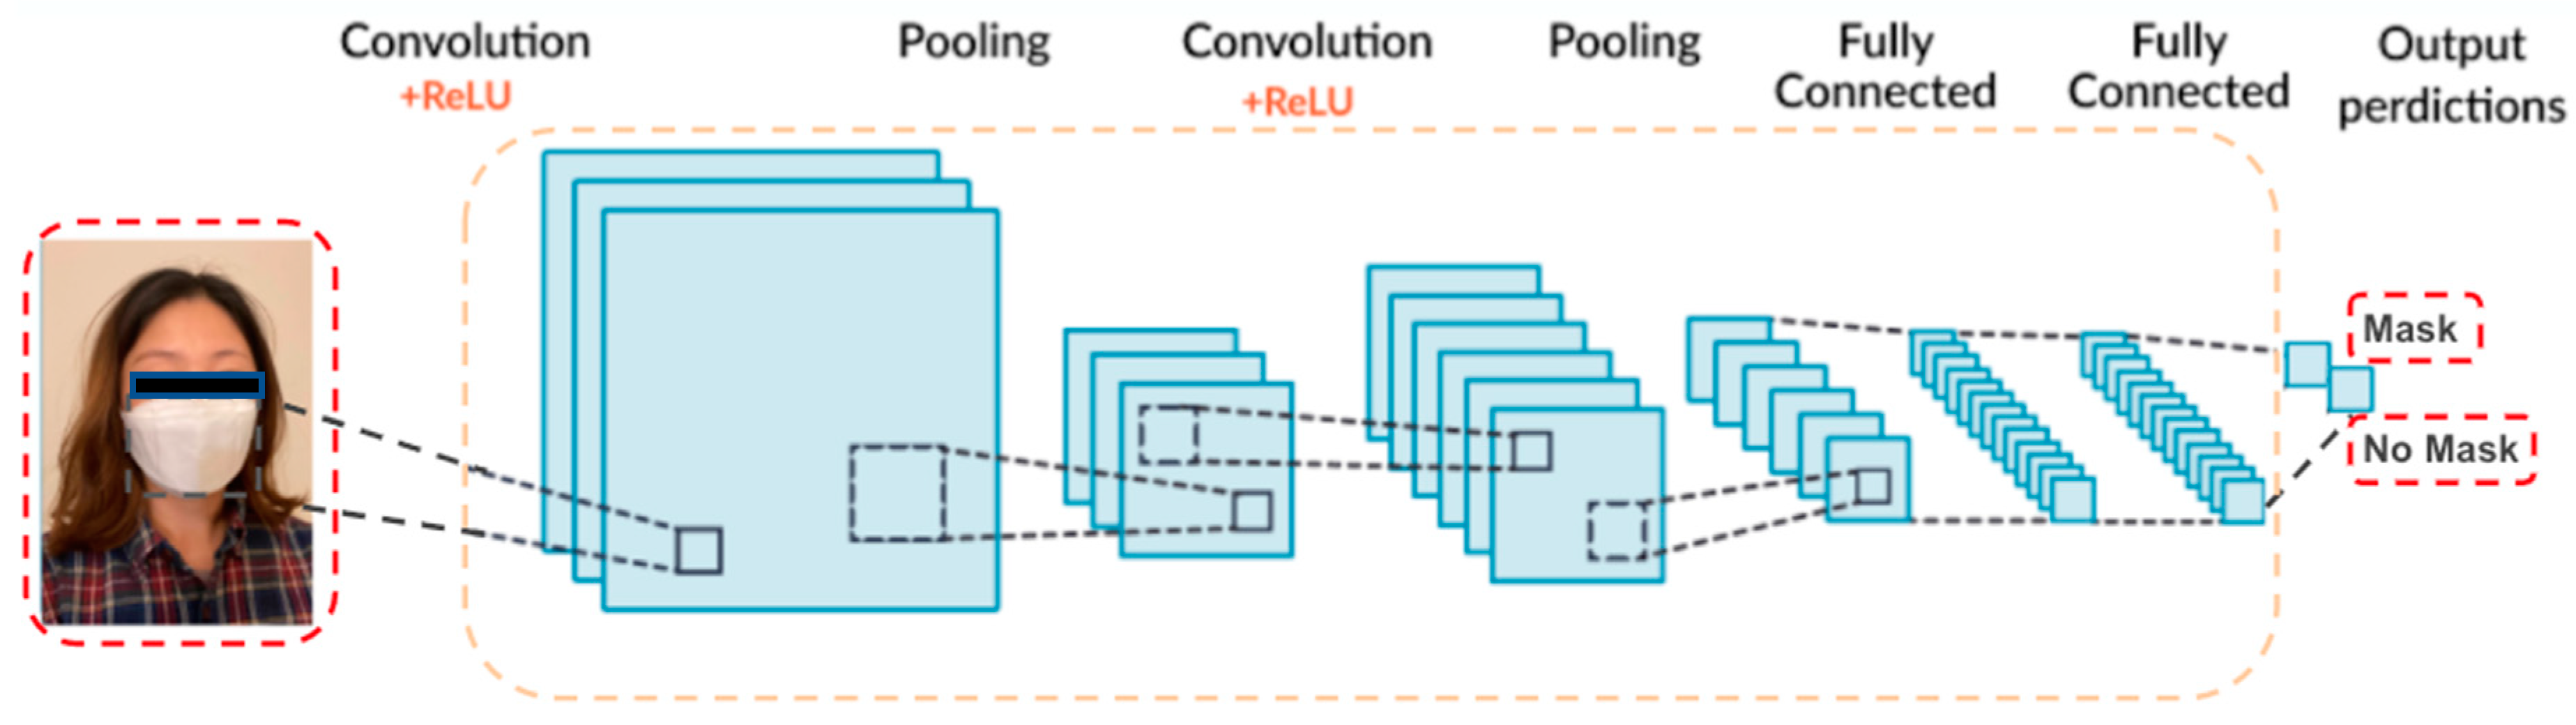

In [13]:
# CNN architecture — 2 Conv layers, 2 Max Pooling, 2 Fully Connected layer (including output layer)

# Initialize the model
model=Sequential()

#The first CNN layer followed by Relu and MaxPooling layers
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#The second convolution layer followed by Relu and MaxPooling layers
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer to stack the output convolutions from second convolution layer
model.add(Flatten())
# Dropout to prevent model overfitting to data
model.add(Dropout(0.5))
#Dense layer of 50 neurons
model.add(Dense(50,activation='relu'))
# The Final layer with two outputs for two categories
# Softmax to give us the probability that the image is in either category
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [14]:
# Split the test and train data for the model.
# train_data and test_data will be the x train and x test
# train_target and test_target will be the y train and y test
# 20% of the data will be used for testing and 80% of the data will be used for training.

from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)

In [16]:
# A checkpoint is created to monitor to the validation loss and save the best performing model.
# train the model using model.fit and 20% of data is used for validation

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs= 20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
200/200 [==============================] - 183s 918ms/step - loss: 0.4242 - accuracy: 0.8055 - val_loss: 0.7726 - val_accuracy: 0.6506
Epoch 2/20
200/200 [==============================] - 189s 948ms/step - loss: 0.2560 - accuracy: 0.8959 - val_loss: 0.2564 - val_accuracy: 0.8975
Epoch 3/20
200/200 [==============================] - 207s 1s/step - loss: 0.2111 - accuracy: 0.9203 - val_loss: 0.1845 - val_accuracy: 0.9431
Epoch 4/20
200/200 [==============================] - 196s 980ms/step - loss: 0.1649 - accuracy: 0.9353 - val_loss: 0.1803 - val_accuracy: 0.9450
Epoch 5/20
200/200 [==============================] - 183s 915ms/step - loss: 0.1445 - accuracy: 0.9441 - val_loss: 0.2035 - val_accuracy: 0.9350
Epoch 6/20
200/200 [==============================] - 187s 933ms/step - loss: 0.1277 - accuracy: 0.9523 - val_loss: 0.1696 - val_accuracy: 0.9413
Epoch 7/20
200/200 [==============================] - 195s 975ms/step - loss: 0.1057 - accuracy: 0.9620 - val_loss: 0.1412 - va

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 200)       2000      
                                                                 
 activation (Activation)     (None, 98, 98, 200)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 200)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 100)       180100    
                                                                 
 activation_1 (Activation)   (None, 47, 47, 100)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 100)      0         
 2D)                                                    

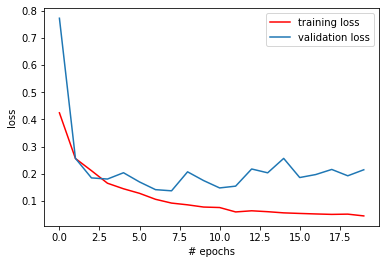

In [18]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

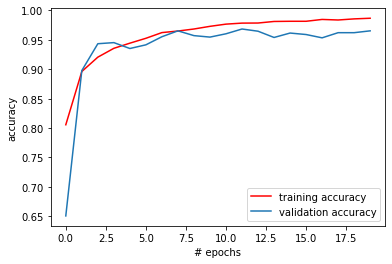

In [19]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [20]:
# model evaluation of test data

print(model.evaluate(test_data,test_target))

63/63 [==============================] - 13s 203ms/step - loss: 0.1869 - accuracy: 0.9670
[0.18687984347343445, 0.9670000076293945]


In [21]:
predictions = (model.predict(test_data) > 0.5).astype("int32")
train_pred= (model.predict(train_data) > 0.5).astype("int32")

In [22]:
# prediction of test data and train data

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
print ("Confusion matrix of test data")
print(classification_report(test_target, predictions))

print ("Confusion matrix of train data")
print(classification_report(train_target, train_pred))


Confusion matrix of test data
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1016
           1       0.95      0.98      0.97       984

   micro avg       0.97      0.97      0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000
 samples avg       0.97      0.97      0.97      2000

Confusion matrix of train data
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3984
           1       0.99      0.99      0.99      4016

   micro avg       0.99      0.99      0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000
 samples avg       0.99      0.99      0.99      8000



## HAAR Cascade Algorithm

In [28]:
# Initialize the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(2, activation = "sigmoid"))
# model.summary()

In [31]:
from tensorflow.keras import optimizers

checkpoint = ModelCheckpoint('HCmodel-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
model.compile(optimizer='rmsprop', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])            

In [32]:
# testing the model on 20 epoches and validation split is 20%

history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
200/200 [==============================] - 50s 247ms/step - loss: 0.3660 - accuracy: 0.8438 - val_loss: 0.2155 - val_accuracy: 0.9244
Epoch 2/20
200/200 [==============================] - 48s 239ms/step - loss: 0.1826 - accuracy: 0.9311 - val_loss: 0.1752 - val_accuracy: 0.9388
Epoch 3/20
200/200 [==============================] - 48s 238ms/step - loss: 0.1274 - accuracy: 0.9500 - val_loss: 0.1469 - val_accuracy: 0.9556
Epoch 4/20
200/200 [==============================] - 49s 247ms/step - loss: 0.0829 - accuracy: 0.9702 - val_loss: 0.1627 - val_accuracy: 0.9513
Epoch 5/20
200/200 [==============================] - 48s 242ms/step - loss: 0.0546 - accuracy: 0.9803 - val_loss: 0.5930 - val_accuracy: 0.8456
Epoch 6/20
200/200 [==============================] - 49s 247ms/step - loss: 0.0484 - accuracy: 0.9855 - val_loss: 0.1849 - val_accuracy: 0.9588
Epoch 7/20
200/200 [==============================] - 50s 249ms/step - loss: 0.0264 - accuracy: 0.9894 - val_loss: 0.2060 - val_ac

In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               4194432   
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                      

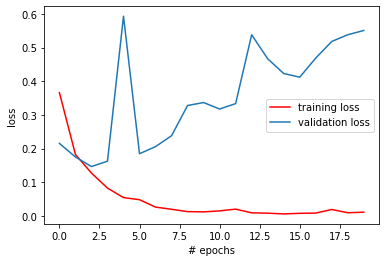

In [34]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

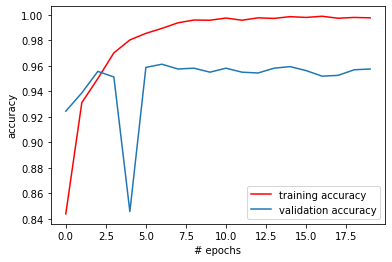

In [35]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [36]:
# Model accuracy on the test data

model.evaluate(test_data, test_target)

63/63 [==============================] - 3s 48ms/step - loss: 0.4525 - accuracy: 0.9585


[0.452467143535614, 0.9585000276565552]

In [37]:
predictions = (model.predict(test_data) > 0.5).astype("int32")

train_pred= (model.predict(train_data) > 0.5).astype("int32")

In [38]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
print ("Confusion matrix of test data")
print(classification_report(test_target, predictions))

print ("Confusion matrix of train data")
print(classification_report(train_target, train_pred))

Confusion matrix of test data
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1016
           1       0.95      0.97      0.96       984

   micro avg       0.96      0.96      0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000
 samples avg       0.96      0.96      0.96      2000

Confusion matrix of train data
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3984
           1       0.99      0.99      0.99      4016

   micro avg       0.99      0.99      0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000
 samples avg       0.99      0.99      0.99      8000



C:\Users\neenu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ANN

In [39]:
# Implimenting the model 

model=Sequential()
import tensorflow as tf
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(100, 100)),
        tf.keras.layers.Dense(128, activation= 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2, activation='softmax')])

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [40]:
# Split the test and train data for the model.
# train_data and test_data will be the x train and x test
# train_target and test_target will be the y train and y test
# 20% of the data will be used for testing and 80% of the data will be used for training.

from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)

In [41]:
# train the model using model.fit and 20% of data is used for validation
checkpoint = ModelCheckpoint('ANNmodel-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
200/200 [==============================] - 2s 11ms/step - loss: 1.0091 - accuracy: 0.6558 - val_loss: 0.5067 - val_accuracy: 0.7394
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 0.5161 - accuracy: 0.7444 - val_loss: 0.4401 - val_accuracy: 0.7806
Epoch 3/20
200/200 [==============================] - 3s 13ms/step - loss: 0.4579 - accuracy: 0.7856 - val_loss: 0.3932 - val_accuracy: 0.8250
Epoch 4/20
200/200 [==============================] - 2s 10ms/step - loss: 0.4266 - accuracy: 0.7981 - val_loss: 0.4493 - val_accuracy: 0.7650
Epoch 5/20
200/200 [==============================] - 2s 10ms/step - loss: 0.4011 - accuracy: 0.8114 - val_loss: 0.3606 - val_accuracy: 0.8331
Epoch 6/20
200/200 [==============================] - 2s 11ms/step - loss: 0.3831 - accuracy: 0.8281 - val_loss: 0.3406 - val_accuracy: 0.8581
Epoch 7/20
200/200 [==============================] - 2s 10ms/step - loss: 0.3661 - accuracy: 0.8405 - val_loss: 0.4284 - val_accuracy: 0.8244

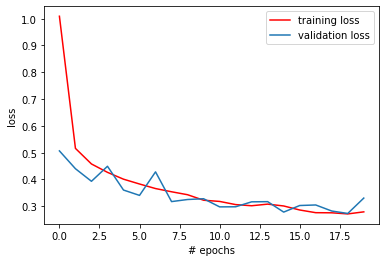

In [42]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

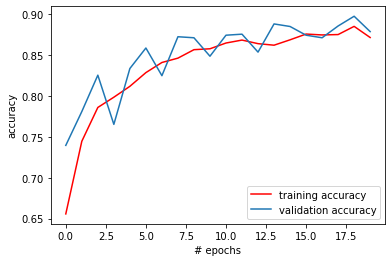

In [43]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [44]:
# test accuracy of the model.

print(model.evaluate(test_data,test_target))

63/63 [==============================] - 0s 2ms/step - loss: 0.3471 - accuracy: 0.8870
[0.34710898995399475, 0.8870000243186951]


In [45]:
predictions = (model.predict(test_data) > 0.5).astype("int32")
#predictions

train_pred= (model.predict(train_data) > 0.5).astype("int32")

In [47]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
print ("Confusion matrix of test data")
print(classification_report(test_target, predictions))

print ("Confusion matrix of train data")
print(classification_report(train_target, train_pred)) 

Confusion matrix of test data
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       987
           1       0.84      0.96      0.90      1013

   micro avg       0.89      0.89      0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000
 samples avg       0.89      0.89      0.89      2000

Confusion matrix of train data
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      4013
           1       0.86      0.97      0.91      3987

   micro avg       0.90      0.90      0.90      8000
   macro avg       0.91      0.90      0.90      8000
weighted avg       0.91      0.90      0.90      8000
 samples avg       0.90      0.90      0.90      8000



# Prediction Using CNN

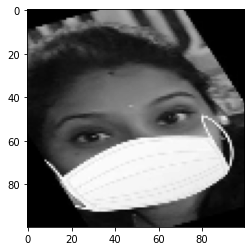

Predicted: 
1
True:
1


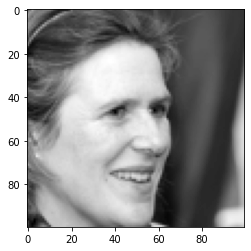

Predicted: 
0
True:
0


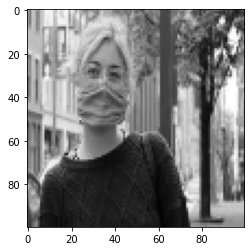

Predicted: 
1
True:
1


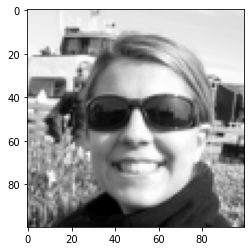

Predicted: 
0
True:
0


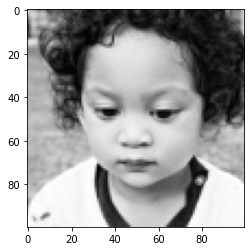

Predicted: 
0
True:
0


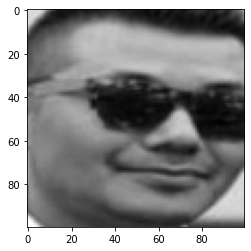

Predicted: 
0
True:
0


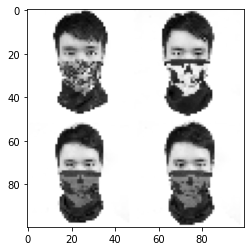

Predicted: 
1
True:
1


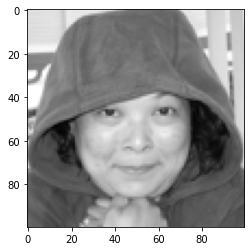

Predicted: 
0
True:
0


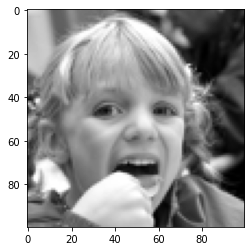

Predicted: 
0
True:
0


In [48]:
Predictions=model.predict(test_data[1:10])
for i in range(1,10):
    X_1=test_data[i]
    Y_1=test_target[i]
    plt.imshow(X_1[:,:,0], cmap='gray')
    plt.show()
    print("Predicted: ")
    print(np.argmax(Predictions[i-10]))
    print("True:")
    print(np.argmax(test_target[i]))

# Detecting mask

## Live Facemask

In [67]:
from keras.models import load_model
import cv2
import numpy as np

In [68]:
model = load_model('model-006.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={1:'MASK',0:'NO MASK'}
color_dict={1:(0,255,0),0:(0,0,255)}

In [69]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
        
        
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()